<a href="https://colab.research.google.com/github/JeanAlmeida1/50_startups/blob/main/Projeto_de_regress%C3%A3o_50_startups.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Objetivo: Previsão do lucro de startups americanas baseado em características como gasto em pesquisa e desenvolvimento, marketing, administração e localização.**

## Importação das bibliotecas e inspeção inicial dos dados 

In [73]:
# Importando bibliotecas de manipulação e visualização de dados
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

# Importando bibliotecas de preparação dos dados
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Importando modelos 
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Importando métricas
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Importando biblioteca para serialização de modelos
import pickle

In [74]:
pd.options.display.float_format = "{:,.2f}".format
sns.set_theme(style='darkgrid')

In [75]:
df = pd.read_csv('50_Startups.csv')

In [76]:
df.head( )

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   R&D Spend        50 non-null     float64
 1   Administration   50 non-null     float64
 2   Marketing Spend  50 non-null     float64
 3   State            50 non-null     object 
 4   Profit           50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


## Análise exploratória dos dados

In [78]:
df['State'].value_counts()

New York      17
California    17
Florida       16
Name: State, dtype: int64

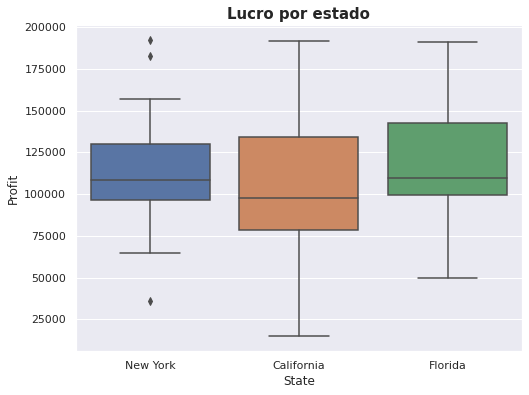

In [79]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df, x='State', y='Profit')
plt.title('Lucro por estado', fontweight='bold', fontsize=15)
plt.show();

In [80]:
df.columns

Index(['R&D Spend', 'Administration', 'Marketing Spend', 'State', 'Profit'], dtype='object')

In [81]:
df.columns[df.columns!='State']

Index(['R&D Spend', 'Administration', 'Marketing Spend', 'Profit'], dtype='object')

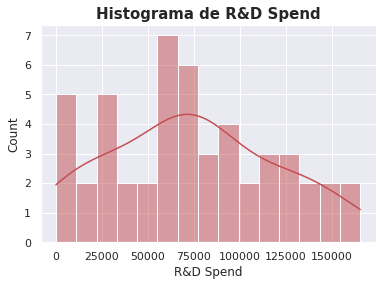

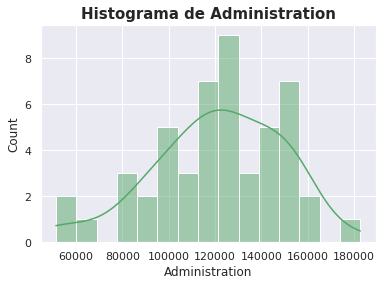

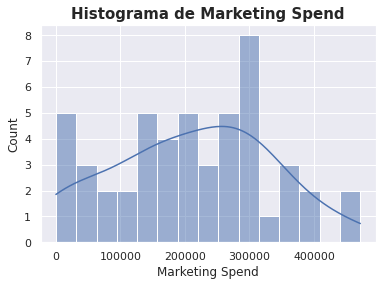

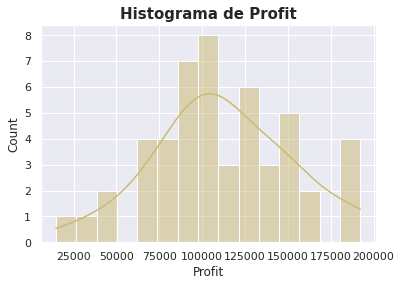

In [82]:
# Histogramas
colors=['r', 'g', 'b', 'y']
for col, color in zip(df.columns[df.columns!='State'], colors):
  sns.histplot(df[col], kde=True, color=color, bins=15)
  plt.title('Histograma de {}'.format(col), fontsize=15, fontweight='bold')
  plt.show()

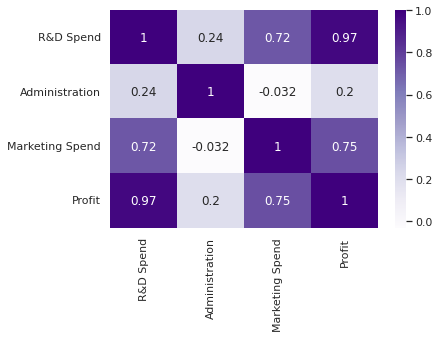

In [83]:
# matriz de correlação 

p = df.corr()
sns.heatmap(p, annot=True, cmap='Purples')
plt.show()

**Relação das variáveis numéricas com o lucro**

In [85]:
df.columns

Index(['R&D Spend', 'Administration', 'Marketing Spend', 'State', 'Profit'], dtype='object')

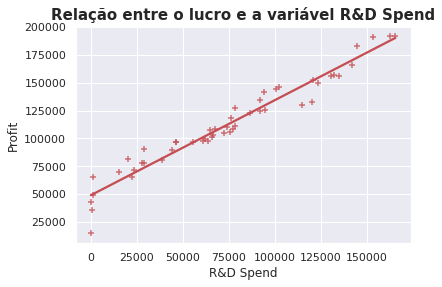

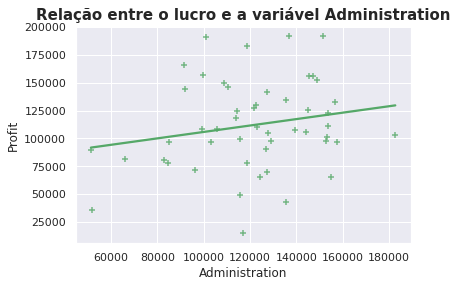

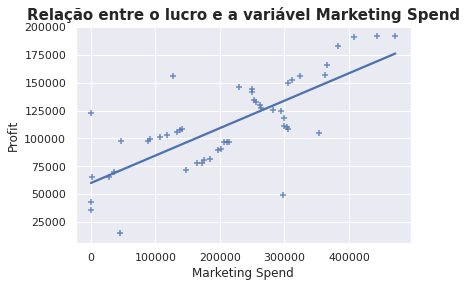

In [89]:
colors=['r', 'g', 'b']
for col, color in zip(df.drop(['State', 'Profit'], axis=1), colors):
  sns.regplot(x=df[col], y=df['Profit'], color=color, marker='+',ci=None)
  plt.title('Relação entre o lucro e a variável {}'.format(col), fontsize=15, fontweight='bold')
  plt.show()

* O Estado da startup tem ligação com o lucro;

* Variáveis aparentemente seguindo distribuições normais; 

* As três variáveis numéricas tem relação positiva com o lucro, em especial o gasto com R&D e Marketing.

* O gasto em R&D está muito ligado ao gasto em marketing, ainda que não tenha relação com o gasto em administração. 

## Preparação dos dados

In [90]:
df.head(3)

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39


In [91]:
# Criando dummies para State 

df_state = pd.get_dummies(df['State'], drop_first=True)
df_state.head(2)

,Florida,New York
0,0,1
1,0,0


In [93]:
# Criando função para normalizar variáveis 

def normalizar(dados):
  Scaler = StandardScaler()
  dados_transformados = Scaler.fit_transform(dados)
  return dados_transformados 

In [95]:
# Adicionando dummies 

df['Florida'] = df_state['Florida']
df['New York'] = df_state['New York']
df = df.drop('State', axis=1)
df.head(3)

,R&D Spend,Administration,Marketing Spend,Profit,Florida,New York
0,165349.20,136897.80,471784.10,192261.83,0,1
1,162597.70,151377.59,443898.53,191792.06,0,0
2,153441.51,101145.55,407934.54,191050.39,1,0


In [96]:
# Definindo variáveis 

X = df[df.columns[df.columns!='Profit']].values
y = df['Profit'].values

In [97]:
# Separando dados em treino e teste (não normalizados)

X_train, X_test, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

In [98]:
X_train.shape, X_test.shape, ytrain.shape, ytest.shape

((40, 5), (10, 5), (40,), (10,))

In [99]:
# Transformando os dados 

Xtrain = normalizar(X_train)
Xtest = normalizar(X_test)

## Modelagem

### Baseline

Previsão simples usando a média do lucro dos dados de treino pra prever os dados de teste. 

In [102]:
# Fazendo a previsão 

mean_baseline = np.mean(ytrain)
y_baseline = np.full((10, ), mean_baseline)

In [103]:
# Valores previstos 
y_baseline

array([115651.7205, 115651.7205, 115651.7205, 115651.7205, 115651.7205,
       115651.7205, 115651.7205, 115651.7205, 115651.7205, 115651.7205])

In [104]:
# Olhando métricas 

R2_base = r2_score(ytest, y_baseline)
MAE_base = mean_absolute_error(ytest, y_baseline)
RMSE_base = np.sqrt(mean_squared_error(ytest, y_baseline))

In [105]:
print('R² da baseline {:.2f}'.format(R2_base))
print('MAE da baseline {:.2f}'.format(MAE_base))
print('RMSE da baseline {:.2f}'.format(RMSE_base))

R² da baseline -0.41
MAE da baseline 25295.29
RMSE da baseline 33776.69


Temos problemas no cálculo do R² quando utilizamos a média como previsão única.

In [106]:
df['Profit'].describe()

count        50.000000
mean     112012.639200
std       40306.180338
min       14681.400000
25%       90138.902500
50%      107978.190000
75%      139765.977500
max      192261.830000
Name: Profit, dtype: float64

O MAE da baseline foi de menos de cerca de 0,6 desvio padrão. Nosso estimador simples não foi tão mal.

### Regressão Linear

A meta é superar a baseline.

In [107]:
# Prevendo os lucros com regressão linear
reg = LinearRegression()
reg.fit(Xtrain, ytrain)
y_reg = reg.predict(Xtest)

In [108]:
# Valores previstos 
y_reg

array([159357.25132999,  97465.99369378, 121058.69045202,  45037.25134919,
       162918.89877532,  48921.50444078, 136363.68103863, 123197.75038506,
       119194.62318615, 143001.56034909])

In [109]:
# Calculando métricas 
R2_reg = r2_score(ytest, y_reg)
MAE_reg = mean_absolute_error(ytest, y_reg)
RMSE_reg = np.sqrt(mean_squared_error(ytest, y_reg))

In [110]:
print('R² da regressão linear {:.2f}'.format(R2_reg))
print('MAE da regressão linear {:.2f}'.format(MAE_reg))
print('RMSE da regressão linear {:.2f}'.format(RMSE_reg))

R² da regressão linear 0.33
MAE da regressão linear 22173.17
RMSE da regressão linear 23229.24


Tivemos uma melhora considerável com a regressão linear em relação à baseline, tanto no MAE quanto RMSE.

### Árvore de Decisão

In [111]:
# Realizando as previsões com a árvore
tree = DecisionTreeRegressor(random_state=42)
tree.fit(Xtrain, ytrain)
y_tree = tree.predict(Xtest)

In [112]:
# Valores preditos 
y_tree

array([156991.12,  96778.92, 126992.93,  14681.4 , 156991.12,  49490.75,
       129917.04, 129917.04, 141585.52, 141585.52])

In [113]:
# Calculando métricas 
R2_tree = r2_score(ytest, y_tree)
MAE_tree = mean_absolute_error(ytest, y_tree)
RMSE_tree = np.sqrt(mean_squared_error(ytest, y_tree))

In [114]:
print('R² da árvore de decisão {:.2f}'.format(R2_tree))
print('MAE da árvore de decisão {:.2f}'.format(MAE_tree))
print('RMSE da árvore de decisão {:.2f}'.format(RMSE_tree))

R² da árvore de decisão -0.06
MAE da árvore de decisão 27085.76
RMSE da árvore de decisão 29335.96


Nossa árvore de decisão performou pior que o modelo de média!. Até agora dos modelos testados, a regressão linear foi o melhor. Vou na sequência utilizar uma floresta aleatória (random forest), que é um conjunto de árvores de decisão. 

### Floresta Aleatória 

In [116]:
# Realizando as previsões
forest = RandomForestRegressor(random_state=42, n_estimators=1000, min_samples_split=10)
forest.fit(Xtrain, ytrain)
y_forest = forest.predict(Xtest)

In [117]:
# Valores previstos 
y_forest

array([163112.06477177,  98554.97332947, 118165.76132521,  53313.24828418,
       163779.78786011,  53242.45371418, 146450.05526131, 131518.31144624,
       126013.57091667, 147783.397546  ])

In [118]:
# Calculando métricas 
R2_forest = r2_score(ytest, y_forest)
MAE_forest = mean_absolute_error(ytest, y_forest)
RMSE_forest = np.sqrt(mean_squared_error(ytest, y_forest))

In [119]:
print('R² da floresta aleatória {:.2f}'.format(R2_forest))
print('MAE da floresta aleatória {:.2f}'.format(MAE_forest))
print('RMSE da floresta aleatória {:.2f}'.format(RMSE_forest))

R² da floresta aleatória 0.13
MAE da floresta aleatória 25059.61
RMSE da floresta aleatória 26590.51


Testei alguns hiperparâmetros diferentes na Floresta Aleatória e melhorei um pouco o modelo; não o suficiente para prever o lucro com um erro menor que a regressão linear

### XGBoost

In [121]:
# Realizando as previsões
xgb = XGBRegressor(random_state=42, max_depth=20, n_estimators=1000)
xgb.fit(Xtrain, ytrain)
y_xgb = xgb.predict(Xtest)

[03:19:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [122]:
# Valores preditos 
y_xgb

array([155057.6  ,  97596.66 , 126347.5  ,  21868.9  , 154272.05 ,
        24375.072, 141836.69 , 127744.25 , 124136.125, 139376.52 ],
      dtype=float32)

In [123]:
# Calculando métricas 
R2_xgb = r2_score(ytest, y_xgb)
MAE_xgb = mean_absolute_error(ytest, y_xgb)
RMSE_xgb = np.sqrt(mean_squared_error(ytest, y_xgb))

In [124]:
print('R² do XGBoost {:.2f}'.format(R2_xgb))
print('MAE do XGBoost {:.2f}'.format(MAE_xgb))
print('RMSE do XGBoost {:.2f}'.format(RMSE_xgb))

R² do XGBoost 0.14
MAE do XGBoost 24675.92
RMSE do XGBoost 26317.72


o XGBoost teve a segunda melhor performance, mas ainda assim ficou atrás da Regressão Linear.  

## Escolha do modelo e deployment

In [ ]:
modelos = ['Baseline', 'Regressão Linear', 'Árvore de Decisão', 'Floresta Aleatória', 'XGBoost']
R2 = [R2_base, R2_reg, R2_tree, R2_forest, R2_xgb]
MAE = [MAE_base, MAE_reg, MAE_tree, MAE_forest, MAE_xgb]
RMSE = [RMSE_base, RMSE_reg, RMSE_tree, RMSE_forest, RMSE_xgb]

In [144]:
resultados = pd.DataFrame() 
resultados['Modelo'] = modelos
resultados['R2'] = R2
resultados['MAE'] = MAE
resultados['RMSE'] = RMSE

In [147]:
resultados

,Modelo,R2,MAE,RMSE
0,Baseline,-0.41,"25,295.29","33,776.69"
1,Regressão Linear,0.33,"22,173.17","23,229.24"
2,Árvore de Decisão,-0.06,"27,085.76","29,335.96"
3,Floresta Aleatória,0.13,"25,059.61","26,590.51"
4,XGBoost,0.14,"24,675.92","26,317.72"


**O melhor modelo foi a regressão linear**

In [150]:
# Os parâmetros do modelo foram: 

print('Intercepto: ', reg.intercept_)
print()
print('Coeficientes: ', reg.coef_)

Intercepto:  115651.72050000001

Coeficientes:  [ 3.81022693e+04 -1.86475430e+03  3.38617581e+03  4.47775725e+02
  3.27289103e+00]


**Salvando o modelo para ser usado em ambiente de produção:**





In [128]:
# Criando um objeto .pkl

with open('modelo_startup_pkl', 'wb') as files:
    pickle.dump(reg, files)

**Dessa forma o modelo está pronto para ser utilizado.** 